In [365]:
import torch
import torch.nn as nn
from torch.optim import SGD

import numpy as np
import matplotlib.pyplot as plt

In [366]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(num_layers-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

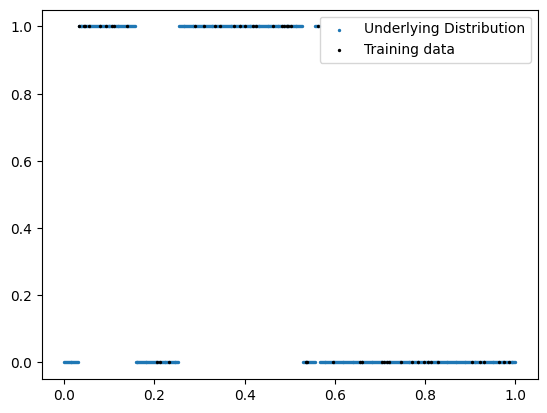

In [367]:
NUM_SAMPLES = 500
NUM_TRAIN_SAMPLES = 50

X=np.linspace(0,1,NUM_SAMPLES)

breaks=np.sort(np.random.random(6))

encode_inputs=lambda x: 1 if (x>breaks[0] and x<breaks[1]) or (x>breaks[2] and x<breaks[3]) or (x>breaks[4] and x<breaks[5]) else 0
Y=np.array([encode_inputs(x) for x in X])

X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).float()

TRAIN_INDICES = np.random.choice(np.arange(NUM_SAMPLES),size=NUM_TRAIN_SAMPLES,replace=False)
X_TRAIN = X[TRAIN_INDICES]
Y_TRAIN = Y[TRAIN_INDICES]

plt.scatter(X,Y,s=2,label='Underlying Distribution')
plt.scatter(X_TRAIN,Y_TRAIN,c='black',s=2,label='Training data')
plt.legend()
plt.savefig('plots/Data_Distribution.png')

In [368]:
INPUT_SIZE = 1
HIDDEN_SIZE = 8
NUM_LAYERS = 3
OUTPUT_SIZE = 2

BATCH_SIZE = 10
LEARNING_RATE = 0.1
NUM_EPOCHS = 1000

In [369]:
def next_batch(inputs, targets, batchSize):
    for i in range(0, inputs.shape[0], batchSize):
        yield (inputs[i:i + batchSize], targets[i:i + batchSize])

def get_bound(feature_dataset, label_dataset, feature_train, label_train, deltas, print_loss=False):
    model = NeuralNet(INPUT_SIZE,HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
    ReLU_glorot_init(model)
            
    opt = SGD(model.parameters(), lr=LEARNING_RATE)
    lossFunc = nn.CrossEntropyLoss()

    num_samples=len(feature_dataset)
    num_train_samples=len(feature_train)

    for epoch in range(NUM_EPOCHS):
        for x,y in next_batch(feature_train,label_train,BATCH_SIZE):
            x=x.reshape((len(x),1))
            outputs = model(x)
            loss = lossFunc(outputs, y.long())
            opt.zero_grad()
            loss.backward()
            opt.step()
        if (epoch+1)%100==0 and print_loss:
            print('Epoch {}: Loss {:.3f}'.format(epoch+1,loss.item()))

    model_outputs=model(feature_dataset.reshape(len(feature_dataset),1)).max(1)[1]
    classified=label_dataset==model_outputs

    p_Delta=(sum(classified)/num_samples).numpy()

    train_error=0
    with torch.no_grad():
        for (x,y) in next_batch(feature_train,label_train,5):
            output=model(x.reshape(len(x),1))
            loss = lossFunc(output, y.long())
            train_error+=loss.item()*len(x)
        train_error=train_error/num_train_samples

    true_error=0
    C=0
    with torch.no_grad():
        for (x,y) in next_batch(feature_dataset,label_dataset,1):
            output=model(x.reshape(len(x),1))
            loss = lossFunc(output, y.long())
            if C<loss.item():
                C=loss.item()
            true_error+=loss.item()*len(x)
        true_error=true_error/num_samples
    bounds=[]
    for delta in deltas:
        log_component = np.log((1-p_Delta+np.sqrt((1-p_Delta)**2+4*delta**(1/num_train_samples)*p_Delta))/(2*delta**(1/num_train_samples)))

        bounds.append(train_error+np.sqrt(C**2*log_component/2))
    
    return train_error, true_error, bounds, p_Delta

In [370]:
NUM_TESTS=500
N_DELTA=10
DELTAS=[0.01,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.25]


train_errors=[]
test_errors=[]
p_Deltas=[]
trial_bounds=[[] for n in range(N_DELTA)]
emp_prob=np.zeros(len(DELTAS))

for k in range(NUM_TESTS):
    tr_er, ts_er, bs, p = get_bound(X,Y,X_TRAIN,Y_TRAIN,DELTAS)
    train_errors.append(tr_er)
    test_errors.append(ts_er)
    p_Deltas.append(p)
    for n, b in enumerate(bs):
        trial_bounds[n].append(b)
        if ts_er<b:
            emp_prob[n]+=1
    print('Trial {} Training Error {:.3f} Test Error {:.3f}'.format(k+1,tr_er,ts_er))
emp_prob=emp_prob/NUM_TESTS
print(emp_prob)

Trial 1 Training Error 0.079 Test Error 0.358
Trial 2 Training Error 0.215 Test Error 0.282
Trial 3 Training Error 0.108 Test Error 0.301
Trial 4 Training Error 0.218 Test Error 0.290
Trial 5 Training Error 0.085 Test Error 0.342
Trial 6 Training Error 0.213 Test Error 0.284
Trial 7 Training Error 0.207 Test Error 0.281
Trial 8 Training Error 0.079 Test Error 0.438
Trial 9 Training Error 0.251 Test Error 0.366
Trial 10 Training Error 0.081 Test Error 0.493
Trial 11 Training Error 0.147 Test Error 0.293
Trial 12 Training Error 0.165 Test Error 0.307
Trial 13 Training Error 0.243 Test Error 0.362
Trial 14 Training Error 0.251 Test Error 0.366
Trial 15 Training Error 0.142 Test Error 0.261
Trial 16 Training Error 0.247 Test Error 0.367
Trial 17 Training Error 0.078 Test Error 0.327
Trial 18 Training Error 0.077 Test Error 0.260
Trial 19 Training Error 0.095 Test Error 0.339
Trial 20 Training Error 0.251 Test Error 0.366
Trial 21 Training Error 0.080 Test Error 0.343
Trial 22 Training Erro

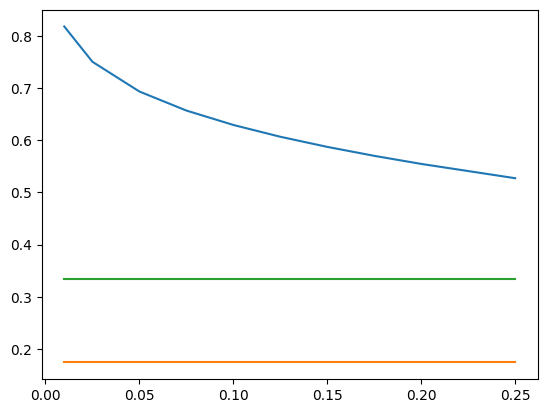

In [371]:
avg_tr_errs=sum(train_errors)/len(train_errors)
avg_ts_errs=sum(test_errors)/len(test_errors)
avg_bounds=[]
for k in range(N_DELTA):
    avg_bounds.append(sum(trial_bounds[k])/len(trial_bounds[k]))
plt.plot(DELTAS,avg_bounds)
plt.plot(DELTAS,avg_tr_errs*np.ones_like(DELTAS))
plt.plot(DELTAS,avg_ts_errs*np.ones_like(DELTAS))

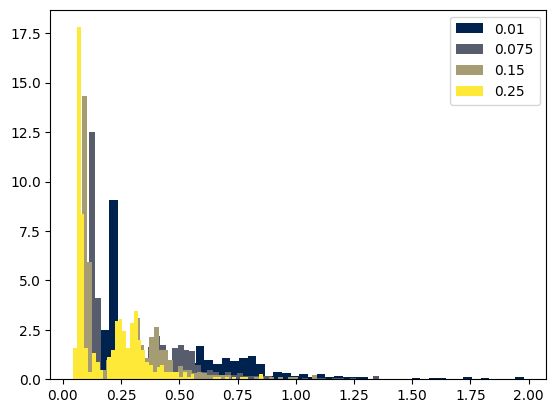

In [372]:
colors = plt.cm.cividis(np.linspace(0, 1, N_DELTA))

for m in range(2):
    for n in range(5):
        if (5*m+n)%3==0:
            ts_errs=np.array(test_errors)
            bs=np.array(trial_bounds[5*m+n])
            tightness=bs-ts_errs
            plt.hist(tightness,bins=50,density=True,label=round(DELTAS[5*m+n],3),color=colors[5*m+n])
plt.legend()

plt.savefig('plots/Bound_Distributions.png')

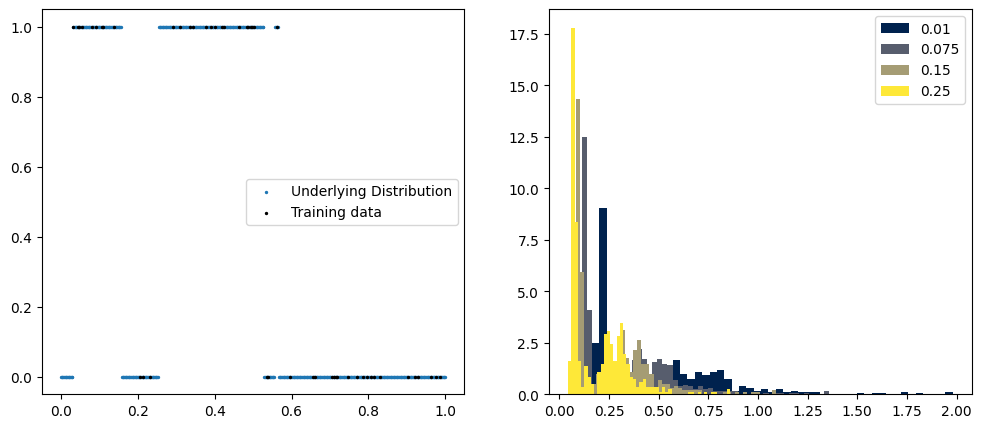

In [373]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

axs[0].scatter(X,Y,s=2,label='Underlying Distribution')
axs[0].scatter(X_TRAIN,Y_TRAIN,c='black',s=2,label='Training data')
axs[0].legend()

colors = plt.cm.cividis(np.linspace(0, 1, N_DELTA))

for m in range(2):
    for n in range(5):
        if (5*m+n)%3==0:
            ts_errs=np.array(test_errors)
            bs=np.array(trial_bounds[5*m+n])
            tightness=bs-ts_errs
            axs[1].hist(tightness,bins=50,density=True,label=round(DELTAS[5*m+n],3),color=colors[5*m+n])
axs[1].legend()

plt.savefig('plots/Data_Bounds_Distribution.png')